In [7]:
! aws s3 cp s3://pneumonia-chest ./test --recursive

download: s3://pneumonia-chest/input/train/PNEUMONIA/person1294_bacteria_3257.jpeg to test/input/train/PNEUMONIA/person1294_bacteria_3257.jpeg
download: s3://pneumonia-chest/input/train/PNEUMONIA/person1288_virus_2211.jpeg to test/input/train/PNEUMONIA/person1288_virus_2211.jpeg
download: s3://pneumonia-chest/input/train/PNEUMONIA/person1291_virus_2217.jpeg to test/input/train/PNEUMONIA/person1291_virus_2217.jpeg
download: s3://pneumonia-chest/input/train/PNEUMONIA/person1290_bacteria_3253.jpeg to test/input/train/PNEUMONIA/person1290_bacteria_3253.jpeg
download: s3://pneumonia-chest/input/train/PNEUMONIA/person128_virus_261.jpeg to test/input/train/PNEUMONIA/person128_virus_261.jpeg
download: s3://pneumonia-chest/input/train/PNEUMONIA/person1292_virus_2218.jpeg to test/input/train/PNEUMONIA/person1292_virus_2218.jpeg
download: s3://pneumonia-chest/input/train/PNEUMONIA/person1293_virus_2219.jpeg to test/input/train/PNEUMONIA/person1293_virus_2219.jpeg
download: s3://pneumonia-chest/in

In [8]:
# General libraries
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Deep learning libraries
#import keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import Model,load_model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight 

# Setting seeds for reproducibility
seed = 232
from tensorflow.keras import layers
from tensorflow.compat.v1 import ConfigProto,InteractiveSession
np.random.seed(seed)
tf.set_random_seed(seed)
#tf.random.set_random_seed(seed)
print(tf.__version__)
model_str= 'CNN_Pneumonia_150imagesize_E500_B32'

1.15.0


In [9]:
# !pip install -U scikit-image
# !pip install mlxtend 

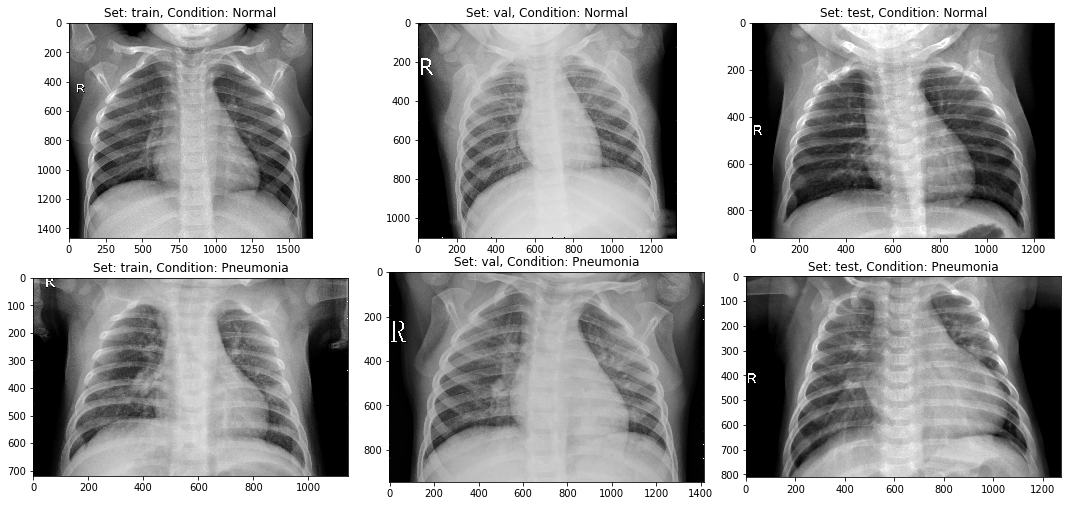

In [10]:
# input_path = '../input/chest_xray/chest_xray/'
input_path = 'test/input/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))
plt.savefig("Data_set Imgaes"+model_str+'.jpg')

In [11]:
# Distribution of our datasets
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))
    

Set: train, normal images: 1339, pneumonia images: 3875
Set: val, normal images: 8, pneumonia images: 8
Set: test, normal images: 234, pneumonia images: 390


In [12]:
# input_path = '../input/chest_xray/chest_xray/'
input_path = 'test/input/'

def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            #img = tf.image.resize(img, (img_dims, img_dims)) 
            #img = tf.image.resize_images(img, (img_dims, img_dims)) 
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels


In [13]:
# Hyperparameters
img_dims = 150
EPOCHS =10
batch_size = 32

# Getting the data
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5214 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
inputs = Input(shape=(img_dims, img_dims, 3))
 
    
 
# # 0st conv block
# x = Conv2D(filters=32, kernel_size=(4, 4), activation='relu')(inputs)  
# x = MaxPooling2D(pool_size=(4, 4))(x)

# Ist conv block
x = Conv2D(filters=64, kernel_size=(4, 4), activation='relu')(inputs)  
x = Conv2D(filters=64, kernel_size=(4, 4), activation='relu')(x)
x = MaxPooling2D(pool_size=(4, 4))(x)

# 2nd conv block
x = Conv2D(filters=128, kernel_size=(4, 4), activation='relu')(x) 
x = MaxPooling2D(pool_size=(4, 4))(x)


# 3rd conv block
x = Conv2D(filters=256, kernel_size=(4, 4), activation='relu')(x) 
x = MaxPooling2D(pool_size=(4, 4))(x)


# Fourth conv block
x = Conv2D(filters=512, kernel_size=(4, 4), activation='relu',padding='same')(x) 
x = MaxPooling2D(pool_size=(4, 4),padding='same')(x)


# fifth conv block
x = Conv2D(filters=512, kernel_size=(4, 4), activation='relu',padding='same')(x) 
x = MaxPooling2D(pool_size=(4, 4),padding='same')(x)

# sixth conv block
x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu',padding='same')(x) 
x = MaxPooling2D(pool_size=(4, 4),padding='same')(x)
x = Dropout(rate=0.3)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=1024, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(units=256, activation='relu')(x)
x = Dropout(rate=0.2)(x) 
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.2)(x) 
x = Dense(units=32, activation='relu')(x)
x = Dropout(rate=0.2)(x)
# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output) 

In [ ]:
model.summary()
# Open the file
with open(model_str + 'report.txt','w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=2, verbose=2, mode='max',min_lr=0.0002)
early_stop = EarlyStopping(monitor='loss', min_delta=0.1, patience=1, mode='min')


In [ ]:
# Fitting the model
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=EPOCHS, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])


In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open(""+model_str+".json", "w") as json_file:
    json_file.write(""+model_str+"_json")
# serialize weights to HDF5
model.save_weights(model_str+".h5")
print("Saved model to disk")
model.save(model_str+".h5")

In [ ]:
# load weights into new model
model.load_weights(model_str+".h5")
print("Loaded model from disk")
 

In [ ]:
print('\n# Evaluate on test data')
results = model.evaluate(test_data, test_labels, batch_size=32)
print('test loss, test acc:', results)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig('plot'+model_str+'val_acc')

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['acc'][-1])*100, 2)))
print('Val acc: {}'.format(np.round((hist.history['val_acc'][-1])*100, 2)))

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(test_labels, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('AUC_CURVE'+model_str+'.jpg')
plt.show()


In [ ]:
# Get predictions
pred = model.predict(test_data, batch_size=16)
pred = np.argmax(pred, axis=-1)

# Original labels
labels = np.argmax(test_labels, axis=-1)
from sklearn.metrics import classification_report
print(classification_report(test_labels, pred))



In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(test_labels, pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('AUC_CURVE'+model_str+'.jpg')
plt.show()



In [ ]:
# !pip install mlxtend 

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues,colorbar=True)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.savefig('confusion_matrix'+model_str+'.jpg')
plt.show()

In [ ]:
# !pip install scikit-image
# !pip install --upgrade pip
# !pip install -U scikit-image


In [ ]:
import tensorflow.keras.backend as K
from skimage import data, color, io, img_as_float
def get_heatmap(processed_image, class_idx):
    # we want the activations for the predicted label
    class_output = model.output[:, class_idx]
    
    # choose the last conv layer in your model
    last_conv_layer = model.get_layer('conv2d_102')
    # get the gradients wrt to the last conv layer
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    print(grads)
   # we pool the gradients over all the axes leaving out the channel dimension
    pooled_grads = K.mean(grads, axis=(0,1,2))
    print(pooled_grads)
    # Define a function that generates the values for the output and gradients
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    
    # get the values
    grads_values, conv_ouput_values = iterate([processed_image])
    
    # iterate over each feature map in your conv output and multiply
    # the gradient values with the conv output values. This gives an 
    # indication of "how important a feature is"
    for i in range(512): # we have 512 features in our last conv layer
        conv_ouput_values[:,:,i] *= grads_values[i]
    
    # create a heatmap
    heatmap = np.mean(conv_ouput_values, axis=-1)
    
    # remove negative values
    heatmap = np.maximum(heatmap, 0)
    
    # normalize
    heatmap /= heatmap.max()
    
    return heatmap

In [ ]:
import cv2
# select the sample and read the corresponding image and label
sample_image = cv2.imread('../test/input/test/PNEUMONIA/person100_bacteria_480.jpeg')
# pre-process the image
sample_image = cv2.resize(sample_image, (150,150))
if sample_image.shape[2] ==1:
            sample_image = np.dstack([sample_image, sample_image, sample_image])
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_image = sample_image.astype(np.float32)/255.
sample_label = 1
    
    
sample_image_processed = np.expand_dims(sample_image, axis=0)
#since we pass only one image,we expand dim to include
                                                             
#batch size 1
    
# get the label predicted by our original model
pred_label = np.argmax(model.predict(sample_image_processed), axis=-1)[0]
    


In [ ]:
# get the heatmap for class activation map(CAM)
heatmap = get_heatmap(sample_image_processed, pred_label)
heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
heatmap = heatmap *255
heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_RAINBOW)
#superimpose the heatmap on the image    

sample_image_hsv = color.rgb2hsv(sample_image)
heatmap = color.rgb2hsv(heatmap)

alpha=0.9
sample_image_hsv[..., 0] = heatmap[..., 0]
sample_image_hsv[..., 1] = heatmap[..., 1] * alpha

img_masked = color.hsv2rgb(sample_image_hsv)


In [ ]:
f,ax = plt.subplots(1,2, figsize=(16,6))
ax[0].imshow(sample_image)
ax[0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
ax[0].axis('off')
    
ax[1].imshow(img_masked)
ax[1].set_title("Class Activation Map")
ax[1].axis('off')
plt.savefig('heatmap'+model_str+'.jpg')

plt.show()
